# Discliamer : Most of my work is inspired from this Documentation in [GitBook](https://technocollabs.gitbook.io/mini-project/#project-tasks)

# **Predict Blood Donation for Future Expectancy**


### Forecasting blood supply is a serious and recurrent problem for blood collection managers: in January 2019, "Nationwide, the [Red Cross](https://www.kjrh.com/news/local-news/red-cross-in-blood-donation-crisis) saw 27,000 fewer blood donations over the holidays than they see at other times of the year." Machine learning can be used to learn the patterns in the data to help to predict future blood donations and therefore save more lives.
### In this Project, you will work with data collected from the donor database of Blood Transfusion Service Center in Hsin-Chu City in Taiwan. The center passes its blood transfusion service bus to one university in Hsin-Chu City to gather blood donated about every three months. The dataset, obtained from [the UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center), consists of a random sample of 748 donors. Your task will be to predict if a blood donor will donate within a given time window. You will look at the full model-building process: from inspecting the dataset to using the [tpot](https://github.com/EpistasisLab/tpot) library to automate your Machine Learning pipeline.

# Project Tasks
* Inspecting transfusion.data file
* Loading the blood donations data
* Inspecting transfusion DataFrame
* Creating target column
* Checking target incidence
* Splitting transfusion into train and test datasets
* Selecting model using TPOT
* Checking the variance
* Log normalization
* Training the Logistic regression model
* Conclusion

# Inspecting transfusion.data file


A pictogram of a blood bag with blood donation written in it


![A pictogram of a blood bag with blood donation written in it
](https://assets.datacamp.com/production/project_646/img/blood_donation.png)

### Blood transfusion saves lives - from replacing lost blood during major surgery or a serious injury to treating various illnesses and blood disorders. Ensuring that there's enough blood in supply whenever needed is a serious challenge for the health professionals. According to [WebMD](https://www.webmd.com/a-to-z-guides/blood-transfusion-what-to-know#1), "about 5 million Americans need a blood transfusion every year".
### Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive. We want to predict whether or not a donor will give blood the next time the vehicle comes to campus.
### The data is stored in `datasets/transfusion.data` and it is structured according to RFMTC marketing model (a variation of RFM). We'll explore what that means later in this notebook. First, let's inspect the data

# Importing Libraries & Modules

In [2]:
# import essintial libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# import model modules
from tpot import TPOTClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# import model evaluation modules
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve


# Loading the blood donations data


In [3]:
df = pd.read_csv("../input/blood-transfusion/transfusion_data.csv")
df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


**We now know that we are working with a typical CSV file (i.e., the delimiter is ,, etc.). We proceed to loading the data into memory.**


In [4]:
df.shape

(748, 5)

# Inspecting transfusion DataFrame


### Let's briefly return to our discussion of RFM model. RFM stands for Recency, Frequency and Monetary Value and it is commonly used in marketing for identifying your best customers. In our case, our customers are blood donors.
### RFMTC is a variation of the RFM model. Below is a description of what each column means in our dataset:
### * R (Recency - months since the last donation)
### * F (Frequency - total number of donation)
### * M (Monetary - total blood donated in c.c.)
### * T (Time - months since the first donation)
### a binary variable representing whether he/she donated blood in March 2007 (1 stands for donating blood; 0 stands for not donating blood)
### It looks like every column in our DataFrame has the numeric type, which is exactly what we want when building a machine learning model. Let's verify our hypothesis.

In [5]:
df.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


### All columns have the numeric type !

In [6]:
#checking for null values 
df.isnull().value_counts() 


Recency (months)  Frequency (times)  Monetary (c.c. blood)  Time (months)  whether he/she donated blood in March 2007
False             False              False                  False          False                                         748
dtype: int64

### Great! our Dataset doesn't contain any null values.

# Creating target column
We are aiming to predict the value in `whether he/she donated blood in March 2007` column. Let's rename this it to `target` so that it's more convenient to work with.

In [7]:
df.rename(columns={'whether he/she donated blood in March 2007':'Target'}, inplace=True)

In [8]:
df.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),Target
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


# Checking target incidence
We want to predict whether or not the same donor will give blood the next time the vehicle comes to campus. The model for this is a binary classifier, meaning that there are only 2 possible outcomes:
* `0` - the donor will not give blood
* `1` - the donor will give blood

Target incidence is defined as the number of cases of each individual target value in a dataset. That is, how many 0s in the target column compared to how many 1s? Target incidence gives us an idea of how balanced (or imbalanced) is our dataset.

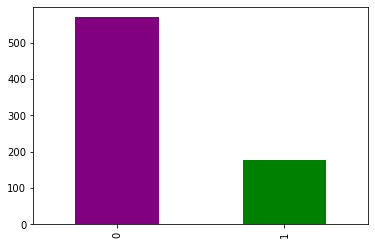

In [9]:
df.Target.value_counts().plot(kind= 'bar', color = ["purple","green"]);

### It is clear that our dataset is imbalanced. 
### So, lets calculate the percentage of cases per each class

In [10]:
class_0 = round(100 * df.Target.value_counts()[0]/df.shape[0])
class_1 = round(100 * df.Target.value_counts()[1]/df.shape[0])
print(f'Percentage of cases per class 0 is {class_0}%')
print(f'Percentage of cases per class 1 is {class_1}%')



Percentage of cases per class 0 is 76%
Percentage of cases per class 1 is 24%


### It turns out that we need to pay extra attention to this imbalance to maintain generalization of our model.

# EDA

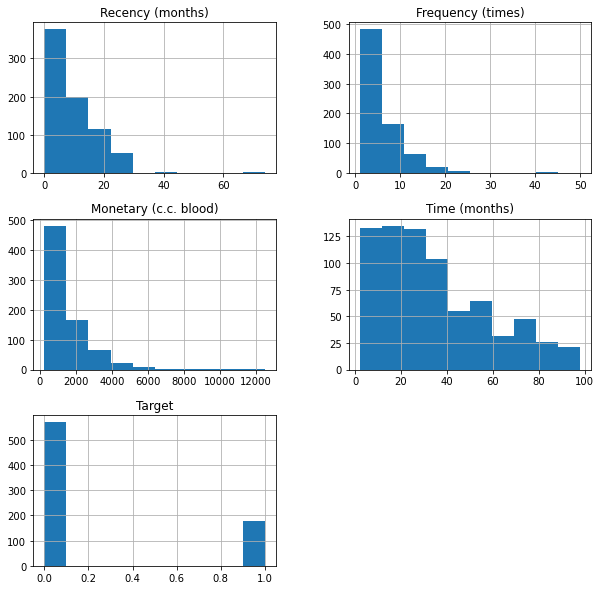

In [11]:
df.hist(figsize=(10,10));

### It is clear that our features are highly right skewed.
### So, we must consider normalization in case of using any model that assumes our data is ditributed normally.

In [12]:
# lets check the correlation among our features
df.corr()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),Target
Recency (months),1.000000,-0.182745,-0.182745,0.160618,-0.279869
Frequency (times),-0.182745,1.000000,1.000000,0.634940,0.218633
Monetary (c.c. blood),-0.182745,1.000000,1.000000,0.634940,0.218633
Time (months),0.160618,0.634940,0.634940,1.000000,-0.035854
Target,-0.279869,0.218633,0.218633,-0.035854,1.000000


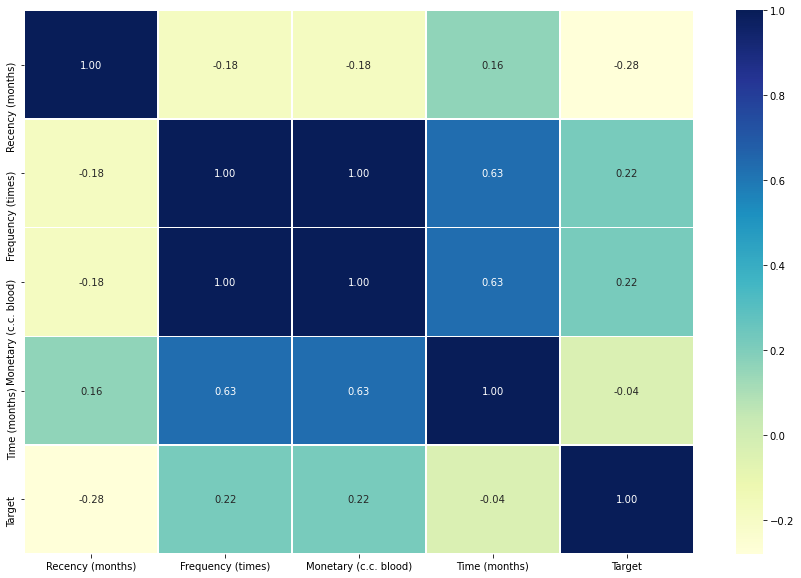

In [13]:

# Lets visualize it with the heatmap instead of looking at the correlation coeffiecients only!


corr_max = df.corr()

fig, ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(corr_max,
              annot = True,
               linewidth = 0.5,
              fmt = ".2f",
              cmap = "YlGnBu")

### It is obvious that we have Multicollinearity between `Frequency(times)` & `Monetary(c.c. blood)` which has a bad impact on performance of models that assume indpendence of features. 
### Since we have only 4 features, we should test performance before dropping multicolinear features.

# Splitting transfusion into train and test datasets
We'll now use `train_test_split()` method to split `transfusion` DataFrame.
Target incidence informed us that in our dataset `0`s appear 76% of the time. We want to keep the same structure in train and test datasets, i.e., both datasets must have `0` target incidence of 76%. This is very easy to do using the `train_test_split()` method from the `scikit learn library` - all we need to do is specify the `stratify` parameter. In our case, we'll stratify on the `target` column.

In [14]:
X = df.drop('Target', axis=1)
y= df.Target
X.shape, y.shape

((748, 4), (748,))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify= y) # stratify on our Target
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((501, 4), (247, 4), (501,), (247,))

# Selecting model using TPOT

### [TPOT](https://github.com/EpistasisLab/tpot) is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.

![TPOT Machine Learning Pipeline](https://assets.datacamp.com/production/project_646/img/tpot-ml-pipeline.png)

`TPOT` will automatically explore hundreds of possible pipelines to find the best one for our dataset. Note, the outcome of this search will be a [scikit-learn pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)`, meaning it will include any pre-processing steps as well as the model.
We are using TPOT to help us zero in on one model that we can then explore and optimize further.

### Uncomment the following code to run `TPOT`  

In [16]:

#tpot = TPOTClassifier(generations=100, population_size=100, verbosity=2, random_state=42)
#tpot.fit(X_train, y_train)
#print(tpot.score(X_test, y_test))
#tpot.export('tpot_digits_pipeline.py')

In [17]:
# This is the best pipeline that TPOT generates 
import numpy as np
import pandas as pd
from sklearn.decomposition import FastICA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Normalizer
from sklearn.svm import LinearSVC
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = df
features = tpot_data.drop('Target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['Target'], random_state=42, stratify=df.Target)

# Average CV score on the training set was: 0.8223762376237623
exported_pipeline = make_pipeline(
    FastICA(tol=1.0),
    Normalizer(norm="max"),
    StackingEstimator(estimator=LinearSVC(C=25.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.01)),
    #LogisticRegression(solver='liblinear', class_weight='balanced')
    RandomForestClassifier(bootstrap=False, criterion="entropy", max_features=0.9000000000000001, min_samples_leaf=18, min_samples_split=5, n_estimators=100)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


### Evaluating the suggested model from`TPOT`

In [18]:
print( classification_report(testing_target, results ))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       143
           1       0.50      0.39      0.44        44

    accuracy                           0.76       187
   macro avg       0.66      0.63      0.64       187
weighted avg       0.75      0.76      0.75       187



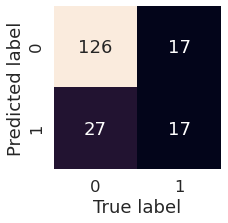

In [19]:
# using seaborn plot confusion matrix  heatmap

sns.set(font_scale=1.5)

def confu_mat_plot(y_test, y_preds):
    fig, ax = plt.subplots(figsize = (3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                    annot = True,
                    cbar=False,
                    fmt=".0f")
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    
    bottom, top = ax.get_ylim()
confu_mat_plot(testing_target, results)

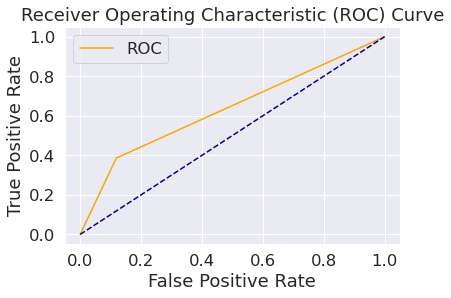

Area under the curve is: 0.6337412587412588


In [20]:

# ROC is the ratio of true positive rate(Recall or Sensitivity) vs false positive rate (1- Specificity)
# import roc

def plot_roc_cur(FPR, TPR):  
    plt.plot(FPR, TPR, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    print(f'Area under the curve is: {roc_auc_score(testing_target, results)}')
    
FPR, TPR, thresholds = roc_curve(testing_target, results) 
plot_roc_cur(FPR, TPR)


# Checking the variance


`TPOT` picked `LogisticRegression` as the best model for our dataset with no pre-processing steps, giving us the AUC score of 0.7850. This is a great starting point. Let's see if we can make it better.
One of the assumptions for linear regression models is that the data and the features we are giving it are related in a linear fashion, or can be measured with a linear distance metric. If a feature in our dataset has a high variance that's an order of magnitude or more greater than the other features, this could impact the model's ability to learn from other features in the dataset.
Correcting for high variance is called normalization. It is one of the possible transformations you do before training a model. Let's check the variance to see if such transformation is needed.

### In my case, The `TPOT` Picked  `Random Forest`which may be due to different configuration than I used.
### However, I will consider using `Logistic Regression`

In [21]:

clf = LogisticRegression( class_weight="balanced",solver='liblinear')
# liblinear is recommended for small dataset

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Calculating Cross validation AUC
mean_cv_score = np.mean(cross_val_score(clf, X_test, y_test, cv=5, scoring='roc_auc'))
print (f'Mean Cross Validation AUC of Logistic Regression is :{mean_cv_score} ')

Mean Cross Validation AUC of Logistic Regression is :0.7602272727272726 


### Lets check the variance

In [33]:
# Check descriptive statsitics 
X.describe()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months)
count,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086
std,8.095396,5.839307,1459.826781,24.376714
min,0.000000,1.000000,250.000000,2.000000
25%,2.750000,2.000000,500.000000,16.000000
50%,7.000000,4.000000,1000.000000,28.000000
75%,14.000000,7.000000,1750.000000,50.000000
max,74.000000,50.000000,12500.000000,98.000000


In [25]:
# Calculate the variance for each column
X.var()

Recency (months)         6.553543e+01
Frequency (times)        3.409751e+01
Monetary (c.c. blood)    2.131094e+06
Time (months)            5.942242e+02
dtype: float64

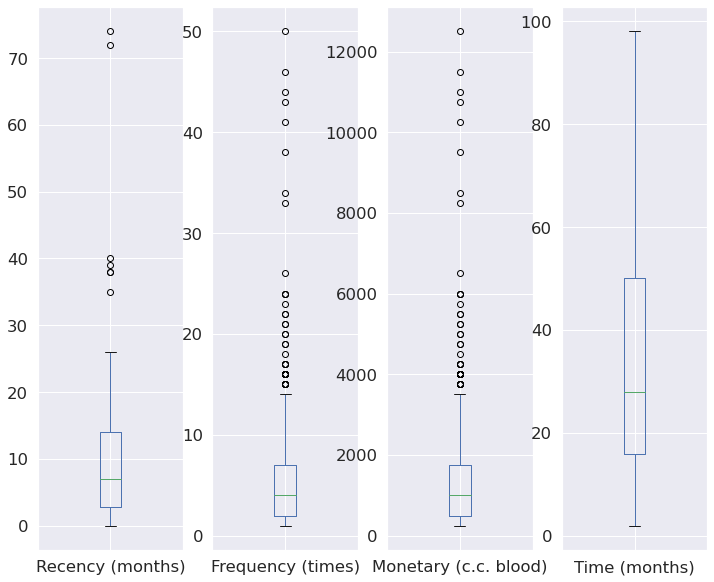

In [26]:
# Visulaize the variance using Box plots 
X.plot(kind='box', subplots= True, figsize=(12,10));

 # Log normalization


#### **One way to correct for high variance is to use log normalization.**


In [70]:
# apply log transformation
X_normalized =  X.apply(lambda x : np.log (x)) ;

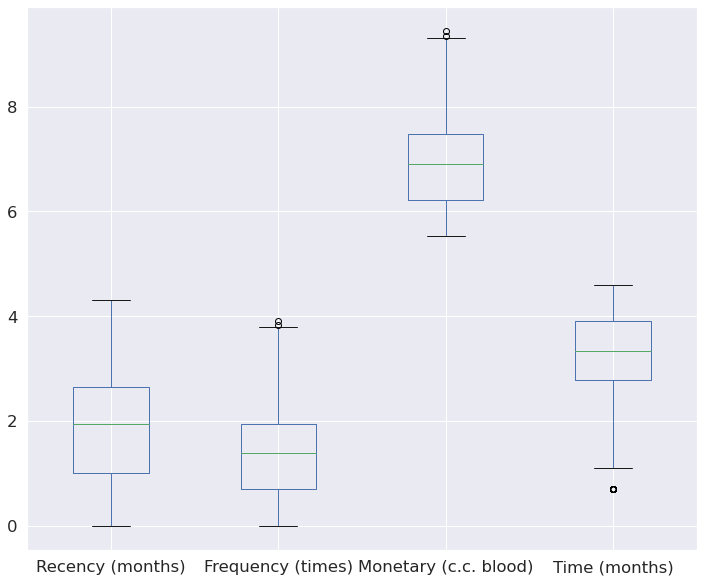

In [75]:
X_normalized.plot(kind='box',  figsize=(12,10));

# Training the Logistic regression model


In [76]:
X_normalized = df.drop('Target', axis=1)
y= df.Target
X.shape, y.shape

((748, 4), (748,))

In [77]:
X_normalized_train, X_normalized_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify= y) # stratify on our Target
X_normalized_train.shape, X_normalized_test.shape, y_train.shape, y_test.shape

((501, 4), (247, 4), (501,), (247,))

In [79]:

clf_2 = LogisticRegression( class_weight="balanced",solver='liblinear')
# liblinear is recommended for small dataset

clf_2.fit(X_normalized_train, y_train)
y_pred_2 = clf.predict(X_normalized_test)
# Calculating Cross validation AUC
mean_cv_score = np.mean(cross_val_score(clf, X_normalized_test, y_test, cv=5, scoring='roc_auc'))
print (f'Mean Cross Validation AUC of Logistic Regression is :{mean_cv_score} ')

Mean Cross Validation AUC of Logistic Regression is :0.7602272727272726 


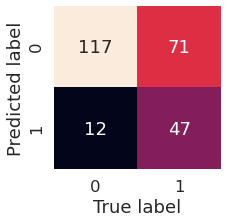

In [82]:
# using seaborn plot confusion matrix  heatmap

sns.set(font_scale=1.5)

def confu_mat_plot(y_test, y_preds):
    fig, ax = plt.subplots(figsize = (3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_2),
                    annot = True,
                    cbar=False,
                    fmt=".0f")
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
    
    bottom, top = ax.get_ylim()
confu_mat_plot(y_test, y_pred_2)

In [83]:
print( classification_report(y_test, y_pred_2 ))

              precision    recall  f1-score   support

           0       0.91      0.62      0.74       188
           1       0.40      0.80      0.53        59

    accuracy                           0.66       247
   macro avg       0.65      0.71      0.63       247
weighted avg       0.79      0.66      0.69       247



# Conclusion

### The demand for blood fluctuates throughout the year. As one [prominent](https://www.kjrh.com/news/local-news/red-cross-in-blood-donation-crisis) example, blood donations slow down during busy holiday seasons. An accurate forecast for the future supply of blood allows for an appropriate action to be taken ahead of time and therefore saving more lives.

### In this notebook, we explored automatic model selection using TPOT and AUC score we got was 0.633. This is better than simply choosing `0` all the time (the target incidence suggests that such a model would have 76% success rate). We then log normalized our training data to mitigate the high variance of the features.
### However, the `AUC` after normalization did not improved, The **Recall** of the class `1` was improved. This improvement will help us determine the potential blood doners more accurate which will allow for an appropriate action to be taken ahead of time and therefore saving more lives 


### Another benefit of using logistic regression model is that it is interpretable. We can analyze how much of the variance in the response variable (`target`) can be explained by other variables in our dataset.


